In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA


In [17]:

# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ハイパーパラメータの設定
num_epochs = 100
batch_size = 128
learning_rate = 0.001
momentum = 0.9

# CIFAR-10データセットの準備
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Using device: cuda


In [18]:

# CNNモデルの定義
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
#        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
#        self.relu3 = nn.ReLU()
#        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
#        x = self.pool3(self.relu3(self.conv3(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        return x

    def get_features(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
#        x = self.pool3(self.relu3(self.conv3(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu4(self.fc1(x))
        return x


In [19]:

# モデルのインスタンス化
net = Net().to(device)

# 損失関数と最適化関数の定義
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

# 学習の記録用リスト
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# 学習ループ
for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(trainloader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

    # テストフェーズ
    net.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss = test_loss / len(testloader)
    test_accuracy = 100 * correct_test / total_test
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

print('Finished Training')


Epoch [1/100], Train Loss: 2.2252, Train Accuracy: 19.08%
Epoch [1/100], Test Loss: 2.0941, Test Accuracy: 26.33%
Epoch [2/100], Train Loss: 1.9958, Train Accuracy: 28.56%
Epoch [2/100], Test Loss: 1.8973, Test Accuracy: 32.46%
Epoch [3/100], Train Loss: 1.8459, Train Accuracy: 33.89%
Epoch [3/100], Test Loss: 1.7678, Test Accuracy: 37.22%
Epoch [4/100], Train Loss: 1.7365, Train Accuracy: 37.39%
Epoch [4/100], Test Loss: 1.6688, Test Accuracy: 39.16%
Epoch [5/100], Train Loss: 1.6521, Train Accuracy: 40.29%
Epoch [5/100], Test Loss: 1.6087, Test Accuracy: 41.58%
Epoch [6/100], Train Loss: 1.5917, Train Accuracy: 42.31%
Epoch [6/100], Test Loss: 1.5595, Test Accuracy: 43.14%
Epoch [7/100], Train Loss: 1.5422, Train Accuracy: 43.97%
Epoch [7/100], Test Loss: 1.5093, Test Accuracy: 45.08%
Epoch [8/100], Train Loss: 1.4982, Train Accuracy: 45.54%
Epoch [8/100], Test Loss: 1.4605, Test Accuracy: 47.01%
Epoch [9/100], Train Loss: 1.4699, Train Accuracy: 46.84%
Epoch [9/100], Test Loss: 1.44

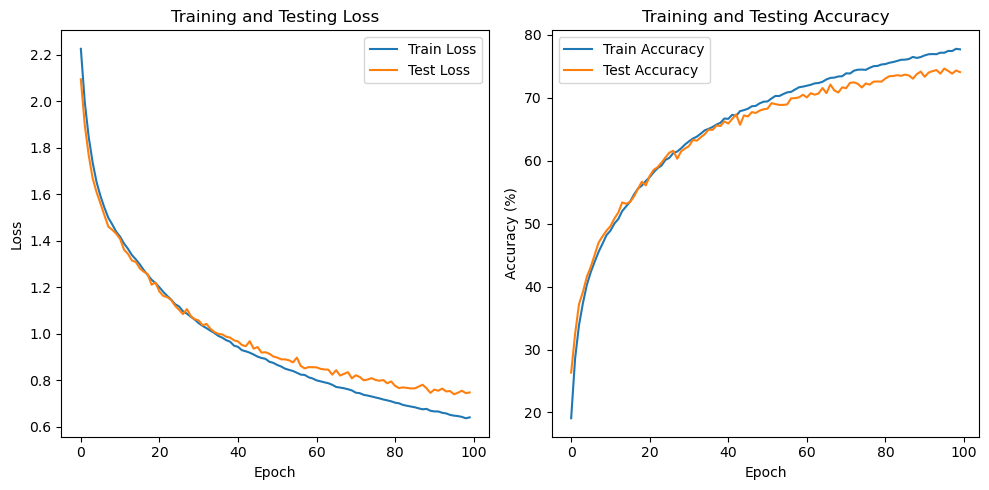

In [20]:

# 学習曲線のプロット
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


(10000, 256) (10000,)


/tmp/ipykernel_24291/2168855339.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', len(classes))
/tmp/ipykernel_24291/2168855339.py:30: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(principal_components[indices, 0], principal_components[indices, 1],


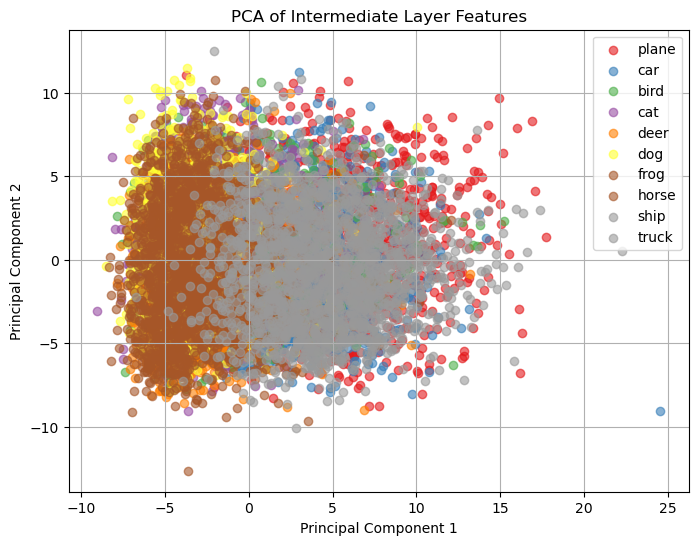

In [21]:

# 中間層の特徴ベクトルの可視化 (一部のデータを使用)
net.eval()
all_features = []
all_labels = []
with torch.no_grad():
    for i, (images, labels) in enumerate(testloader):
#        if i >= 100:  # 最初の10バッチのみ使用 (計算量を抑えるため)
#            break
        images = images.to(device)
        features = net.get_features(images).cpu().numpy()
        all_features.append(features)
        all_labels.append(labels.cpu().numpy())

all_features = np.concatenate(all_features, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
print(all_features.shape, all_labels.shape)

# PCAによる次元削減
pca = PCA(n_components=2)
principal_components = pca.fit_transform(all_features)

# 散布図のプロット
plt.figure(figsize=(8, 6))
#colors = plt.cm.get_cmap('viridis', len(classes))
# より区別しやすいカラーマップに変更
#colors = plt.cm.get_cmap('tab10', len(classes)) 
colors = plt.cm.get_cmap('Set1', len(classes)) 
for i in range(len(classes)):
    indices = np.where(all_labels == i)[0]
    plt.scatter(principal_components[indices, 0], principal_components[indices, 1],
                label=classes[i], alpha=0.6, c=colors(i))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Intermediate Layer Features')
plt.legend()
plt.grid(True)
plt.show()